In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [167]:
import numpy as np
from functools import reduce

import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.image as m_img

from mpl_toolkits.mplot3d import Axes3D

# ALL DIVISION DEFAULTS TO FLOATING POINT DIVISION
from __future__ import division

In [168]:
# Load images into an array

images = []
image_labels = ['0-6', '1-7', '2-8', '3-9', '4-10', '5-11', \
                    '6-12', '7-13', '8-14', '9-15']
for label in image_labels:
    image = img.imread('./series_1/reduced/s1_{}_r.png'.format(label))
    images.append(image)

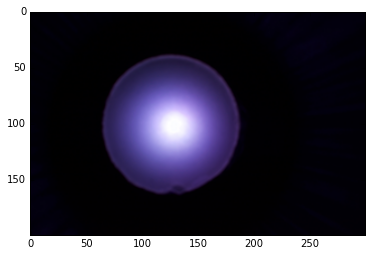

In [175]:
imgplot = plt.imshow(images[2])

In [179]:
def png_to_grayscale(img_png):
    """
    Takes an (m x n x 4)-shape matrix representing an m-by-n
    PNG image with 4 channels (R, G, B, A) and returns a channel-flattened
    (m x n)-shape matrix i.e. a grayscale matrix.
    
    Uses the ITU-R 601-2 luma transform:
    L = R * 299/1000 + G * 587/1000 + B * 114/1000
    """
    img_png = img_png[:, :, 0] * 299/100 + img_png[:, :, 1] * 587/1000 \
        + img_png[:, :, 2] * 114/100
    return img_png / img_png.max()
    
def plot_3d_surface(img_png, stride=10):
    """
    Given a PNG as an array, plots a wireframe.
    """
    x_range = np.arange(img_png.shape[1])
    y_range = np.arange(img_png.shape[0])
    x_range, y_range = np.meshgrid(x_range, y_range)
    z = png_to_grayscale(img_png)
    stride = int(max(img_png.shape[0], img_png.shape[1]) / stride)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # ax.plot_wireframe(x_range, y_range, z, rstride=stride, cstride=stride)
    ax.plot_surface(x_range, y_range, z, rstride=stride, cstride=stride, cmap=cm.OrRd, linewidth=0.5)

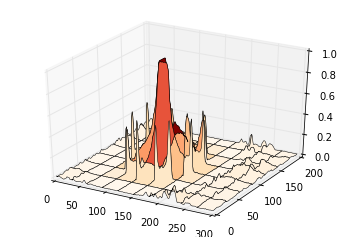

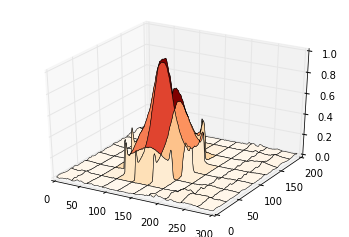

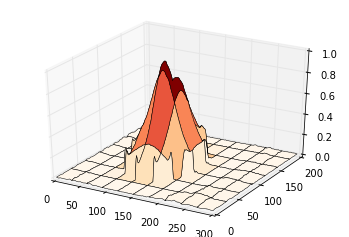

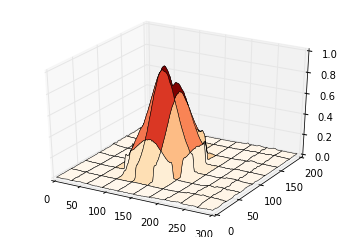

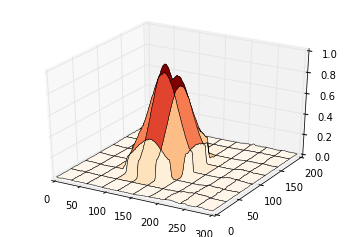

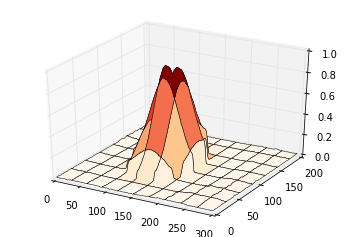

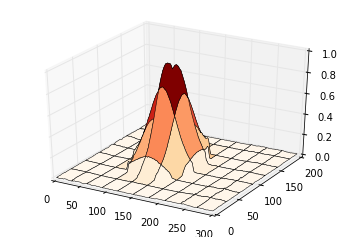

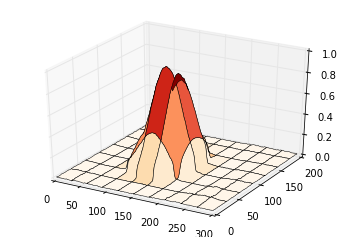

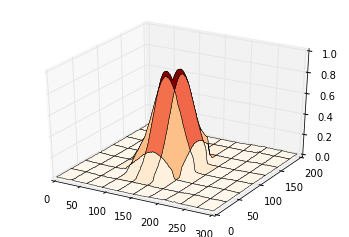

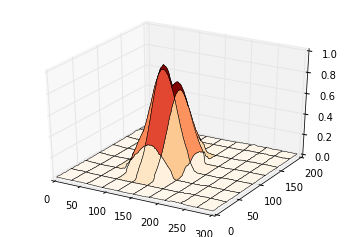

In [181]:
# Plot graphs
for image in images:
    plot_3d_surface(image)
    show()